# BERTweetInteraction.ipynb

### Designation: Demonstration/Debugging/Validation Script

    Purpose: load in the model, weights, and datasets specified, and generate prediction results as well as any additional staticstics.

- Requirements:
    
    Packages: tensorflow, pandas, matplotlib, transformers, sklearn, os

    Datasets (csv's) (selectable): trainingData.csv, testingData.csv (default).

    Model: bertweet9010.h5 (default, we can use others)

- This program will require an internet connection, as it will download the model and tokenizer from the HuggingFace model repository.

    - Please note, all files referenced (input and output) will all be on the folder-level.

### A note on generating predictions
- Although it would not be required to use a GPU for this, but I would still suggest using one for this, if it is available.
- Please refer to BERTweet.ipynb for explanation on the common steps, detailed explanation will be given for parts that are different.

## 1. TensorFlow Standalone Setup

In [5]:
useCPU = False #Choose whether to use CPU or GPU for running the program

import tensorflow as tf
import os
if useCPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.config.list_physical_devices('GPU')

[]

## 2. Importing, downloading, and Building the model

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import InputExample, InputFeatures
with tf.device('/GPU:0'):
    model = TFAutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base",num_labels=3,problem_type="multi_label_classification")
    tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base",num_labels=3)
    model.summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 134309376 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592899    
 ficationHead)                                                   
                                                                 
Total params: 134,902,275
Trainable params: 134,902,275
Non-trainable params: 0
_________________________________________________________________


## 3. Load Weights

In [7]:
model.load_weights('bertweet9010.h5')

## 4. Load CSV

- selectable: testing data, or training data.

In [8]:
dfRaw = pd.read_csv('testingData.csv')
#dfRaw = pd.read_csv('trainingData.csv')
dfRaw

,Unnamed: 0,DATA_COLUMN,LABEL_COLUMN
0,26493,"I started X-Slimmer at eight this morning, it`...",0
1,11488,why won`t the kids sleep,0
2,7782,Jennnnnn richhhh wast to the ed,1
3,18241,LOL! I hate when that happens!! All hyped up ...,1
4,25540,Stuck on NJ Transit for the past twenty minute...,1
...,...,...,...
2744,11645,Yes. Nag twitter. HAHA Thanks. LM.,2
2745,23533,"hm, this not a good medium for much more then...",0
2746,6578,hapee mother`s day t all the mothers out there!,2
2747,5338,Aww maybe i traumatized her.,0


### 4.1. Extract only the text into a new Dataframe, and fill the label column with 0s.

- The program will not use the label column, as it is predicting only based on the text. Having it allows us to use already-written methods to put it into our model.

In [9]:
df = pd.DataFrame()
df['DATA_COLUMN'] = dfRaw.iloc[:,1].astype(str)
df['LABEL_COLUMN'] = 0

## 5. Data Processing, Converting dataframes into supported input formats.

- note: there is only 1 dataframe that needs to be converted.

- Also note: we are using batch size 1 here (at the end), so we are evaluating each and every query individually.

In [10]:
def convertToExamples(data,DATA_COLUMN,LABEL_COLUMN):
    dataOut = data.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                        text_a = x[DATA_COLUMN], 
                        text_b = None,
                        label = x[LABEL_COLUMN]), axis = 1)
    return dataOut 

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

dataInputExamples = convertToExamples(df,'DATA_COLUMN','LABEL_COLUMN')

with tf.device('/GPU:0'):
    dataTensor = convert_examples_to_tf_dataset(list(dataInputExamples), tokenizer)
    dataTensor = dataTensor.batch(1)

/home/acthegreat/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## 6. Predict

- instead of training here, we call model.predict() to get the outputs of our queries.

In [11]:
with tf.device('/GPU:0'):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])
    out = model.predict(dataTensor)
out

TFSequenceClassifierOutput(loss=None, logits=array([[ 2.714901  , -0.3710036 , -2.3270257 ],
       [ 0.6390394 ,  1.6838382 , -2.4399874 ],
       [-0.578817  ,  2.3400283 , -1.958418  ],
       ...,
       [-2.406961  , -0.56785583,  2.9865649 ],
       [ 2.5711346 , -0.45077664, -2.14151   ],
       [ 2.9598632 , -0.7908993 , -2.1495836 ]], dtype=float32), hidden_states=None, attentions=None)

- convert our logits numpy array into a dataframe

In [12]:
outDF = pd.DataFrame(out['logits'])

- for every row, if a column has the highest number, record that column number, as that is what our AI thinks the category of that query is.

In [13]:
outCat = outDF.idxmax(axis=1)
outCat

0       0
1       1
2       1
3       1
4       1
       ..
2744    2
2745    0
2746    2
2747    0
2748    0
Length: 2749, dtype: int64

- For testing purposes, also extract the max value, as it can serve as an indicator as to how confident the model is sure of its predicion on the specified query.

In [14]:
outValue = outDF.max(axis=1)
outValue

0       2.714901
1       1.683838
2       2.340028
3       0.845122
4       0.800888
          ...   
2744    2.817371
2745    2.637920
2746    2.986565
2747    2.571135
2748    2.959863
Length: 2749, dtype: float32

- Concat all of the data into a single DataFrame

In [15]:
overallOut = pd.concat([df['DATA_COLUMN'], outCat, outValue],axis=1)
overallOut

,DATA_COLUMN,0,1
0,"I started X-Slimmer at eight this morning, it`...",0,2.714901
1,why won`t the kids sleep,1,1.683838
2,Jennnnnn richhhh wast to the ed,1,2.340028
3,LOL! I hate when that happens!! All hyped up ...,1,0.845122
4,Stuck on NJ Transit for the past twenty minute...,1,0.800888
...,...,...,...
2744,Yes. Nag twitter. HAHA Thanks. LM.,2,2.817371
2745,"hm, this not a good medium for much more then...",0,2.637920
2746,hapee mother`s day t all the mothers out there!,2,2.986565
2747,Aww maybe i traumatized her.,0,2.571135


- save the dataframe into a CSV for manual verification

In [16]:
overallOut.to_csv('test2.csv')

## 7. (DEMO) graphs

- a set of code to generate a graph representing the predictions

0    929
1    975
2    845
Name: 0, dtype: int64


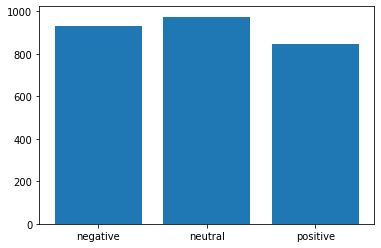

In [17]:
import matplotlib.pyplot as plt
plt.bar(['negative','neutral','positive'], overallOut[0].value_counts().sort_index())
print(overallOut[0].value_counts().sort_index())

## 8. (Validation) Attaching the predictions to the original dataframe

In [18]:
dfRaw['prediction'] = outCat
dfRaw

,Unnamed: 0,DATA_COLUMN,LABEL_COLUMN,prediction
0,26493,"I started X-Slimmer at eight this morning, it`...",0,0
1,11488,why won`t the kids sleep,0,1
2,7782,Jennnnnn richhhh wast to the ed,1,1
3,18241,LOL! I hate when that happens!! All hyped up ...,1,1
4,25540,Stuck on NJ Transit for the past twenty minute...,1,1
...,...,...,...,...
2744,11645,Yes. Nag twitter. HAHA Thanks. LM.,2,2
2745,23533,"hm, this not a good medium for much more then...",0,0
2746,6578,hapee mother`s day t all the mothers out there!,2,2
2747,5338,Aww maybe i traumatized her.,0,0


- saving it for manual/automatic validation

In [19]:
dfRaw.to_csv('testing_set_predictions.csv')
#dfRaw.to_csv('training_set_predictions.csv')